In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving diabetes.csv to diabetes.csv


In [3]:
X = pd.read_csv('diabetes.csv')

In [4]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
X.isnull().values.any()

False

In [6]:
y = X.pop('Outcome')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [9]:
!pip install optuna

     |████████████████████████████████| 308 kB 7.8 MB/s 
     |████████████████████████████████| 81 kB 8.8 MB/s 
     |████████████████████████████████| 210 kB 47.6 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 146 kB 59.7 MB/s 
     |████████████████████████████████| 112 kB 57.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=7c20682bab1bcff705cf81c9721b34e1683f0719a22369a4442c86d6a5d0d2de
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [10]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Grid search

In [26]:
def objective_gs(trial):
    C_vals = trial.suggest_float("C", 1e-5, 1e5)
    gamma_vals = trial.suggest_float('gamma', 1e-5, 1e5)
    clf_obj = SVC(kernel='rbf', C=C_vals, gamma=gamma_vals)
    score = cross_val_score(clf_obj, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

In [27]:
%%time
search_space = {'C': np.logspace(-5, 5, 20), 'gamma': np.logspace(-5, 5 ,20)}
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective_gs)

CPU times: user 12.4 s, sys: 344 ms, total: 12.8 s
Wall time: 1min 11s


In [28]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [29]:
print('SVC, grid search, best trial:')
print(study.best_trial.params)
print('SVC, grid search, best accuracy:')
print(study.best_value)
print('SVC, grid search, best trial number:')
print(study.best_trial.number)

SVC, grid search, best trial:
{'C': 0.5455594781168515, 'gamma': 3.359818286283781e-05}
SVC, grid search, best accuracy:
0.7745932848736586
SVC, grid search, best trial number:
238


In [30]:
fig = optuna.visualization.plot_contour(study, params=["C", "gamma"])
fig.show()

In [31]:
def evaluate_accuracy(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy = (pred == y_test).mean()
    return accuracy

In [32]:
model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
print('SVC, grid search, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, grid search, accuracy on test:
0.7229437229437229


In [33]:
accs = []
for i in range(5):
    model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
    accs.append(evaluate_accuracy(model, X_train, y_train, X_test, y_test))
print('SVC, grid search, average accuracy on test, 5 fits:')
print(np.mean(accs))

SVC, grid search, average accuracy on test, 5 fits:
0.7229437229437229


# Random search

In [34]:
def objective(trial):
    C_vals = trial.suggest_float("C", 1e-5, 1e5, log=True)
    gamma_vals = trial.suggest_float('gamma', 1e-5, 1e5, log=True)
    clf_obj = SVC(kernel='rbf', C=C_vals, gamma=gamma_vals)
    score = cross_val_score(clf_obj, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

In [35]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=400)

CPU times: user 9.99 s, sys: 354 ms, total: 10.3 s
Wall time: 1min 2s


In [36]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [37]:
print('SVC, random search, best trial:')
print(study.best_trial.params)
print('SVC, random_search, best accuracy:')
print(study.best_value)
print('SVC, random search, best trial number')
print(study.best_trial.number)

SVC, random search, best trial:
{'C': 3.1581216878294676, 'gamma': 1.0415139339288037e-05}
SVC, random_search, best accuracy:
0.7820353063343718
SVC, random search, best trial number
267


In [38]:
fig = optuna.visualization.plot_contour(study, params=["C", "gamma"])
fig.show()

In [39]:
model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
print('SVC, random search, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, random search, accuracy on test:
0.7316017316017316


In [40]:
accs = []
for i in range(5):
    model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
    accs.append(evaluate_accuracy(model, X_train, y_train, X_test, y_test))
print('SVC, random search, average accuracy on test, 5 fits:')
print(np.mean(accs))

SVC, random search, average accuracy on test, 5 fits:
0.7316017316017316


# NSGA-II

In [89]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler())
study.optimize(objective, n_trials=400)

CPU times: user 10.6 s, sys: 379 ms, total: 11 s
Wall time: 1min 9s


In [90]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [91]:
print('SVC, NSGA-II, best trial:')
print(study.best_trial.params)
print('SVC, NSGA-II, best accuracy:')
print(study.best_value)
print('SVC, NSGA-II, best trial number:')
print(study.best_trial.number)

SVC, NSGA-II, best trial:
{'C': 0.842926847758115, 'gamma': 2.323884360941602e-05}
SVC, NSGA-II, best accuracy:
0.7802007615091726
SVC, NSGA-II, best trial number:
40


In [92]:
fig = optuna.visualization.plot_contour(study, params=["C", "gamma"])
fig.show()

In [93]:
model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
print('SVC, NSGA-II, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, NSGA-II, accuracy on test:
0.7186147186147186


In [94]:
accs = []
for i in range(5):
    model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
    accs.append(evaluate_accuracy(model, X_train, y_train, X_test, y_test))
print('SVC, NSGA-II, average accuracy on test, 5 fits:')
print(np.mean(accs))

SVC, NSGA-II, average accuracy on test, 5 fits:
0.7186147186147186


# TPE

In [41]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=400)

CPU times: user 12 s, sys: 405 ms, total: 12.4 s
Wall time: 52.2 s


In [42]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [43]:
print('SVC, TPE, best trial:')
print(study.best_trial.params)
print('SVC, TPE, best accuracy:')
print(study.best_value)
print('SVC, TPE, best trial number:')
print(study.best_trial.number)

SVC, TPE, best trial:
{'C': 3.325785981276453, 'gamma': 1.0032174323653958e-05}
SVC, TPE, best accuracy:
0.7820353063343718
SVC, TPE, best trial number:
348


In [44]:
fig = optuna.visualization.plot_contour(study, params=["C", "gamma"])
fig.show()

In [45]:
model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
print('SVC, TPE, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, TPE, accuracy on test:
0.7316017316017316


In [46]:
accs = []
for i in range(5):
    model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
    accs.append(evaluate_accuracy(model, X_train, y_train, X_test, y_test))
print('SVC, TPE, average accuracy on test, 5 fits:')
print(np.mean(accs))

SVC, TPE, average accuracy on test, 5 fits:
0.7316017316017316


# CMA-ES

In [65]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=400)

CPU times: user 10.5 s, sys: 376 ms, total: 10.9 s
Wall time: 35.2 s


In [66]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [67]:
print('SVC, CMA-ES, best trial:')
print(study.best_trial.params)
print('SVC, CMA-ES, best accuracy:')
print(study.best_value)
print('SVC, CMA-ES, best trial number:')
print(study.best_trial.number)

SVC, CMA-ES, best trial:
{'C': 3.251127163055471, 'gamma': 1.012211319697134e-05}
SVC, CMA-ES, best accuracy:
0.7820353063343718
SVC, CMA-ES, best trial number:
182


In [68]:
fig = optuna.visualization.plot_contour(study, params=["C", "gamma"])
fig.show()

In [69]:
model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
print('SVC, CMA-ES, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, CMA-ES, accuracy on test:
0.7316017316017316


In [70]:
accs = []
for i in range(5):
    model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
    accs.append(evaluate_accuracy(model, X_train, y_train, X_test, y_test))
print('SVC, CMA-ES, average accuracy on test, 5 fits:')
print(np.mean(accs))

SVC, CMA-ES, average accuracy on test, 5 fits:
0.7316017316017316


# Bayesian optimization

In [95]:
! pip install scikit-optimize

     |████████████████████████████████| 100 kB 4.5 MB/s 


In [96]:
from skopt import BayesSearchCV

In [97]:
%%time 
opt = BayesSearchCV(
    SVC(kernel='rbf'), 
    {
        'C': (1e-5, 1e5, 'log-uniform'),
        'gamma': (1e-5, 1e5, 'log-uniform')
    },
    n_iter=400,
    cv=5,
    scoring='accuracy'
)
opt.fit(X_train, y_train)

CPU times: user 2h 15min 19s, sys: 42min 30s, total: 2h 57min 50s
Wall time: 2h 12min 45s


In [98]:
print('SVC, BO, best trial:')
print(opt.best_params_)
print('SVC, BO, best accuracy:')
print(opt.best_score_)
print('SVC, BO, best trial number:')
print(opt.best_index_)

SVC, BO, best trial:
OrderedDict([('C', 3.1309467683890593), ('gamma', 1.0556068915284895e-05)])
SVC, BO, best accuracy:
0.7820353063343718
SVC, BO, best trial number:
318


In [99]:
from skopt.plots import plot_objective, plot_convergence, plot_gaussian_process, plot_evaluations

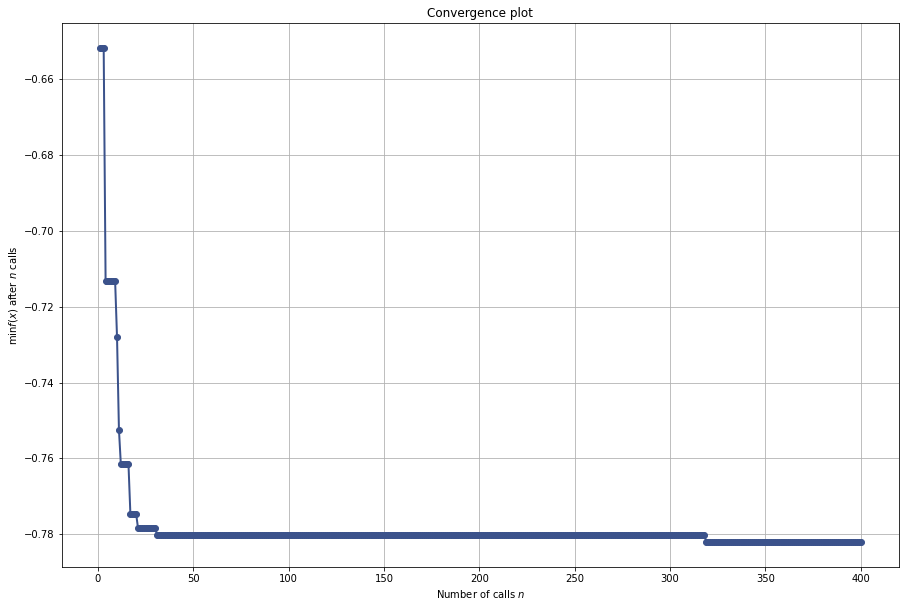

In [100]:
plt.figure(figsize=(15, 10))
vis = plot_convergence(*opt.optimizer_results_)

<Figure size 1440x1080 with 0 Axes>

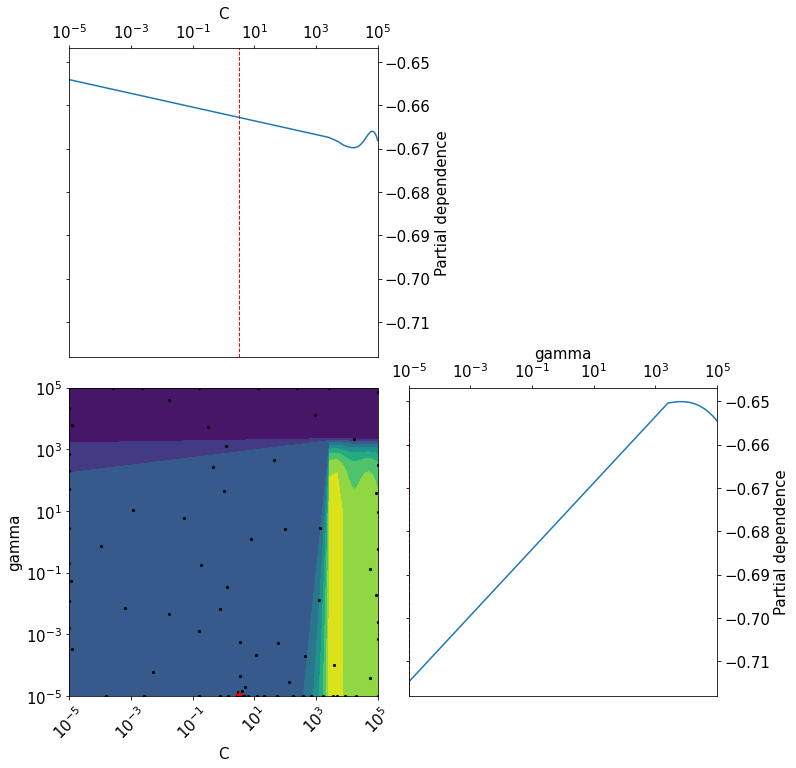

In [101]:
plt.rc('font', size=15)
plt.rc('lines', mew=5)
plt.figure(figsize=(20, 15))
plot_objective(*opt.optimizer_results_, size=5)
plt.savefig(fname='SVC_BCW_BO.pdf')

In [102]:
model = SVC(kernel='rbf', C=opt.best_params_['C'], gamma=opt.best_params_['gamma'])
print('SVC, BO, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, BO, accuracy on test:
0.7316017316017316


In [103]:
accs = []
for i in range(5):
    model = SVC(kernel='rbf', C=opt.best_params_['C'], gamma=opt.best_params_['gamma'])
    accs.append(evaluate_accuracy(model, X_train, y_train, X_test, y_test))
print('SVC, BO, average accuracy on test, 5 fits:')
print(np.mean(accs))

SVC, BO, average accuracy on test, 5 fits:
0.7316017316017316
